#### load data

In [301]:
!nvidia-smi

Thu Jan  2 09:18:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:07:00.0 Off |                    0 |
| N/A   39C    P0             81W /  400W |   39300MiB /  40960MiB |     88%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [302]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [303]:
!pip install matplotlib


In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [305]:
data = pd.read_csv("Project_final_data.csv")

In [306]:
data.head()

,CVE_ID,CAPEC_ID,Similarity_Score,CVE_Description,CAPEC_Description,Execution Flow
0,CVE-2023-25262,664.0,0.555823,Stimulsoft GmbH Stimulsoft Designer (Web) 2023...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
1,CVE-2023-46725,664.0,0.552269,FoodCoopShop is open source software for food ...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
2,CVE-2023-38491,209.0,0.516406,Kirby is a content management system. A vulner...,An adversary creates a file with scripting con...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...
3,CVE-2023-22493,664.0,0.504184,RSSHub is an open source RSS feed generator. R...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
4,CVE-2023-2152,219.0,0.485873,A vulnerability has been found in SourceCodest...,An attacker subverts an intermediate system us...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...


In [307]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12904 entries, 0 to 12903
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CVE_ID             12904 non-null  object 
 1   CAPEC_ID           12904 non-null  float64
 2   Similarity_Score   12904 non-null  float64
 3   CVE_Description    12904 non-null  object 
 4   CAPEC_Description  12904 non-null  object 
 5   Execution Flow     12904 non-null  object 
dtypes: float64(2), object(4)
memory usage: 605.0+ KB


In [308]:
data.isnull().sum()

CVE_ID               0
CAPEC_ID             0
Similarity_Score     0
CVE_Description      0
CAPEC_Description    0
Execution Flow       0
dtype: int64

In [309]:
data.dropna(inplace=True)

In [310]:
data.isnull().sum()

CVE_ID               0
CAPEC_ID             0
Similarity_Score     0
CVE_Description      0
CAPEC_Description    0
Execution Flow       0
dtype: int64

In [311]:
df = data[['CVE_Description', 'Execution Flow']]

In [312]:
df.head()

,CVE_Description,Execution Flow
0,Stimulsoft GmbH Stimulsoft Designer (Web) 2023...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
1,FoodCoopShop is open source software for food ...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
2,Kirby is a content management system. A vulner...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...
3,RSSHub is an open source RSS feed generator. R...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
4,A vulnerability has been found in SourceCodest...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...


In [313]:
!pip install transformers

In [314]:
!pip install torch torchvision torchaudio

In [315]:
!pip install scikit-learn

In [316]:
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, AdamW
import torch
from sklearn.metrics import accuracy_score

In [317]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [318]:
# Preprocessing Function
def preprocess_data(cve_description, execution_flow, tokenizer):
    """
    Tokenizes the CVE description and execution flow for the model.
    """
    input_text = f"generate execution flow: {cve_description}"
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids
    labels = tokenizer(execution_flow, return_tensors="pt", padding=True, truncation=True).input_ids
    return input_ids.squeeze(0), labels.squeeze(0)

In [319]:
# Preprocess Data from DataFrame
def preprocess_data_from_dataframe(df, tokenizer):
    """
    Preprocess input data for training from a DataFrame.
    """
    preprocessed_data = []
    for _, row in df.iterrows():
        cve_description = row['CVE_Description']
        execution_flow = row['Execution Flow']
        input_ids, labels = preprocess_data(cve_description, execution_flow, tokenizer)
        preprocessed_data.append((input_ids, labels))
    return preprocessed_data

In [320]:
# Function to calculate BLEU score
def calculate_bleu_score(predictions, references):
    """
    Calculate BLEU score for a list of predictions and references.
    """
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if len(bleu_scores) > 0 else 0
    return avg_bleu

def train_model_from_dataframe(model, tokenizer, df, epochs=3, batch_size=2, lr=5e-5, val_df=None):
    """
    Fine-tune the model using a DataFrame.
    """
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_data = preprocess_data_from_dataframe(df, tokenizer)

    # For tracking loss, BLEU, and accuracy
    epoch_losses = []
    epoch_bleu_scores = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        predictions = []
        references = []

        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i + batch_size]
            input_ids, labels = [], []

            for cve_desc, exec_flow in batch:
                input_ids.append(cve_desc)
                labels.append(exec_flow)

            input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True).to(model.device)
            labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True).to(model.device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_data)
        epoch_losses.append(avg_loss)

        # Evaluate on validation data and calculate BLEU score
        if val_df is not None:
            model.eval()
            val_predictions = []
            val_references = []
            total_val_loss = 0

            for _, row in val_df.iterrows():
                cve_description = row['Description']
                actual_execution_flow = row['Execution Flow']
                generated_flow = generate_execution_flow(model, tokenizer, cve_description)
                
                # Print actual vs generated output for debugging
                # print(f"Generated Flow: {generated_flow}")
                # print(f"Actual Execution Flow: {actual_execution_flow}")
                
                val_predictions.append(generated_flow)
                val_references.append(actual_execution_flow)

                # Calculate validation loss
                input_ids, labels = preprocess_data(cve_description, actual_execution_flow, tokenizer)
                input_ids = input_ids.unsqueeze(0).to(model.device)
                labels = labels.unsqueeze(0).to(model.device)
                outputs = model(input_ids=input_ids, labels=labels)
                val_loss = outputs.loss.item()
                total_val_loss += val_loss

            avg_val_loss = total_val_loss / len(val_df)
            avg_bleu = calculate_bleu_score(val_predictions, val_references)
            epoch_bleu_scores.append(avg_bleu)

            print(f"Validation Loss: {avg_val_loss:.4f}, Validation BLEU Score: {avg_bleu:.4f}")
        else:
            epoch_bleu_scores.append(0)  # If no validation set, append 0 BLEU score
            print(f"Validation BLEU Score: 0")

        print(f"Average Training Loss: {avg_loss:.4f}")

    return model, epoch_losses, epoch_bleu_scores

In [321]:
from tqdm import tqdm
import torch
from transformers import AdamW

def train_model_from_dataframe(model, tokenizer, df, epochs=3, batch_size=2, lr=5e-5, val_df=None):
    """
    Fine-tune the model using a DataFrame with a real-time progress bar.
    """
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_data = preprocess_data_from_dataframe(df, tokenizer)

    # For tracking loss, BLEU, and accuracy
    epoch_losses = []
    epoch_bleu_scores = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        predictions = []
        references = []

        # Create a progress bar for each epoch
        train_progress_bar = tqdm(range(0, len(train_data), batch_size), desc="Training Progress", unit="batch")

        for i in train_progress_bar:
            batch = train_data[i:i + batch_size]
            input_ids, labels = [], []

            for cve_desc, exec_flow in batch:
                input_ids.append(cve_desc)
                labels.append(exec_flow)

            input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True).to(model.device)
            labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True).to(model.device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update progress bar with the current loss
            train_progress_bar.set_postfix(loss=total_loss / (i + 1))

        avg_loss = total_loss / len(train_data)
        epoch_losses.append(avg_loss)

        # Evaluate on validation data and calculate BLEU score
        if val_df is not None:
            model.eval()
            val_predictions = []
            val_references = []
            total_val_loss = 0

            # Create a progress bar for validation
            val_progress_bar = tqdm(val_df.iterrows(), desc="Validation Progress", unit="batch", total=len(val_df))

            for _, row in val_progress_bar:
                cve_description = row['CVE_Description']
                actual_execution_flow = row['Execution Flow']
                generated_flow = generate_execution_flow(model, tokenizer, cve_description)
                
                val_predictions.append(generated_flow)
                val_references.append(actual_execution_flow)

                # Calculate validation loss
                input_ids, labels = preprocess_data(cve_description, actual_execution_flow, tokenizer)
                input_ids = input_ids.unsqueeze(0).to(model.device)
                labels = labels.unsqueeze(0).to(model.device)
                outputs = model(input_ids=input_ids, labels=labels)
                val_loss = outputs.loss.item()
                total_val_loss += val_loss

                # Update validation progress bar
                val_progress_bar.set_postfix(val_loss=total_val_loss / len(val_predictions))

            avg_val_loss = total_val_loss / len(val_df)
            avg_bleu = calculate_bleu_score(val_predictions, val_references)
            epoch_bleu_scores.append(avg_bleu)

            print(f"Validation Loss: {avg_val_loss:.4f}, Validation BLEU Score: {avg_bleu:.4f}")
        else:
            epoch_bleu_scores.append(0)  # If no validation set, append 0 BLEU score
            print(f"Validation BLEU Score: 0")

        print(f"Average Training Loss: {avg_loss:.4f}")

    return model, epoch_losses, epoch_bleu_scores


In [322]:
!pip install nltk

In [323]:
import nltk
nltk.download('punkt')  # Commonly needed for tokenization

[nltk_data] Downloading package punkt to /home/shalini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [324]:
!pip install rouge-score


In [325]:
!pip install py-rouge


In [326]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [327]:
# Function to Calculate BLEU and ROUGE Scores
# def evaluate_model_with_text_metrics(model, tokenizer, df):
#     model.eval()
#     predictions = []
#     references = []

#     for _, row in df.iterrows():
#         cve_description = row['CVE_Description']
#         actual_execution_flow = row['Execution Flow']

#         generated_flow = generate_execution_flow(model, tokenizer, cve_description)
#         predictions.append(generated_flow)
#         references.append(actual_execution_flow)

#     # Calculate BLEU Score
#     bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
#     avg_bleu = sum(bleu_scores) / len(bleu_scores)

#     # Calculate ROUGE Scores
#     rouge = Rouge()
#     rouge_scores = rouge.get_scores(predictions, references, avg=True)

#     print(f"Average BLEU Score: {avg_bleu:.4f}")
#     print(f"ROUGE Scores: {rouge_scores}")

#     return avg_bleu, rouge_scores


# Function to Calculate BLEU Score
def evaluate_model_with_text_metrics(model, tokenizer, df):
    model.eval()
    predictions = []
    references = []

    for _, row in df.iterrows():
        cve_description = row['CVE_Description']
        actual_execution_flow = row['Execution Flow']

        generated_flow = generate_execution_flow(model, tokenizer, cve_description)
        predictions.append(generated_flow)
        references.append(actual_execution_flow)

    # Calculate BLEU Score
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    print(f"Average BLEU Score: {avg_bleu:.4f}")

    # Return only BLEU Score
    return avg_bleu





In [328]:
# Function to plot training progress
def plot_training_progress(epoch_losses, epoch_bleu_scores):
    """
    Plot the training progress including loss and BLEU score.
    """
    epochs = range(1, len(epoch_losses) + 1)
    
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')

    # Plot BLEU Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_bleu_scores, label='Validation BLEU Score', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score vs Epochs')

    plt.tight_layout()
    plt.show()

In [352]:
# Function to generate execution flow (for evaluation)
def generate_execution_flow(model, tokenizer, cve_description):
    """
    Generate the execution flow for a given CVE description.
    """
    model.eval()
    device = model.device

    input_text = f"generate execution flow for the given CVE description: {cve_description}"
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

    output_ids = model.generate(
        input_ids,
        max_length=1000,
        num_beams=4,
        temperature=0.7,
        top_k=50,
        early_stopping=True
    )
    execution_flow = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return execution_flow


In [330]:
# train model

In [331]:
# from transformers import T5ForConditionalGeneration, T5Tokenizer

# # Load the pre-trained T5 model and tokenizer
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = T5ForConditionalGeneration.from_pretrained("t5-small")

# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
# model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")



In [332]:
!pip install sentencepiece


In [333]:
!pip uninstall -y sentencepiece
!pip install sentencepiece


Found existing installation: sentencepiece 0.2.0
Uninstalling sentencepiece-0.2.0:
  Successfully uninstalled sentencepiece-0.2.0
  Using cached sentencepiece-0.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
Using cached sentencepiece-0.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [334]:
import sys
print(sys.executable)


/home/shalini/kmsha_mtp/bin/python3


In [335]:
pip show transformers


Name: transformers
Version: 4.47.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/shalini/kmsha_mtp/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [336]:
model_name="t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

In [337]:
# Function 6: Fine-tune the Model
def fine_tune_t5_model(df, val_df, model, tokenizer, epochs=3, batch_size=2, lr=5e-5):
    """
    Fine-tune the T5 model and evaluate it.
    """

    # Train the model
    print("Starting training...")
    model, epoch_losses, epoch_bleu_scores = train_model_from_dataframe(model, tokenizer, df, epochs=epochs, batch_size=batch_size, lr=lr, val_df=val_df)

    # Plot training progress
    plot_training_progress(epoch_losses, epoch_bleu_scores)

    # Evaluate the model
    print("Evaluating model...")
    # accuracy = evaluate_model(model, tokenizer, df)
    #avg_bleu, rouge_scores = evaluate_model_with_text_metrics(model, tokenizer, df)
    avg_bleu = evaluate_model_with_text_metrics(model, tokenizer, df)

    # print(f"Average BLEU Score: {avg_bleu:.4f}")
    # print(f"ROUGE Scores: {rouge_scores}")
    
    return model

In [338]:
data = df.head(250)

In [339]:
data.shape

(250, 2)

In [340]:
from sklearn.model_selection import train_test_split

# Split your dataframe into training and validation sets (80% for training, 20% for validation)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

Starting training...


/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50


Training Progress: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.34batch/s, loss=2.51]
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.37batch/s, val_loss=3.89]
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/nltk/t

Validation Loss: 3.8872, Validation BLEU Score: 0.0000
Average Training Loss: 2.5014
Epoch 2/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.35batch/s, val_loss=3.12]


Validation Loss: 3.1243, Validation BLEU Score: 0.0000
Average Training Loss: 1.4352
Epoch 3/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.10batch/s, val_loss=2.62]


Validation Loss: 2.6193, Validation BLEU Score: 0.0000
Average Training Loss: 1.1665
Epoch 4/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04batch/s, val_loss=2.21]


Validation Loss: 2.2146, Validation BLEU Score: 0.0000
Average Training Loss: 0.9577
Epoch 5/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00batch/s, val_loss=1.84]


Validation Loss: 1.8448, Validation BLEU Score: 0.0000
Average Training Loss: 0.7673
Epoch 6/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/batch, val_loss=1.54]


Validation Loss: 1.5425, Validation BLEU Score: 0.0030
Average Training Loss: 0.5957
Epoch 7/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/batch, val_loss=1.33]


Validation Loss: 1.3341, Validation BLEU Score: 0.0031
Average Training Loss: 0.4762
Epoch 8/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/batch, val_loss=1.18]


Validation Loss: 1.1850, Validation BLEU Score: 0.0560
Average Training Loss: 0.3996
Epoch 9/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.22s/batch, val_loss=1.07]


Validation Loss: 1.0714, Validation BLEU Score: 0.0356
Average Training Loss: 0.3460
Epoch 10/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.26s/batch, val_loss=0.97]


Validation Loss: 0.9701, Validation BLEU Score: 0.0557
Average Training Loss: 0.3013
Epoch 11/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/batch, val_loss=0.88]


Validation Loss: 0.8805, Validation BLEU Score: 0.0488
Average Training Loss: 0.2619
Epoch 12/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/batch, val_loss=0.802]


Validation Loss: 0.8021, Validation BLEU Score: 0.1062
Average Training Loss: 0.2269
Epoch 13/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/batch, val_loss=0.733]


Validation Loss: 0.7326, Validation BLEU Score: 0.1220
Average Training Loss: 0.1957
Epoch 14/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.32s/batch, val_loss=0.672]


Validation Loss: 0.6716, Validation BLEU Score: 0.1089
Average Training Loss: 0.1680
Epoch 15/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.34s/batch, val_loss=0.621]


Validation Loss: 0.6206, Validation BLEU Score: 0.1282
Average Training Loss: 0.1438
Epoch 16/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/batch, val_loss=0.575]


Validation Loss: 0.5747, Validation BLEU Score: 0.1322
Average Training Loss: 0.1232
Epoch 17/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/batch, val_loss=0.536]


Validation Loss: 0.5358, Validation BLEU Score: 0.1598
Average Training Loss: 0.1052
Epoch 18/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/batch, val_loss=0.504]


Validation Loss: 0.5037, Validation BLEU Score: 0.1366
Average Training Loss: 0.0898
Epoch 19/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.48s/batch, val_loss=0.477]


Validation Loss: 0.4770, Validation BLEU Score: 0.1138
Average Training Loss: 0.0767
Epoch 20/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.46s/batch, val_loss=0.453]


Validation Loss: 0.4534, Validation BLEU Score: 0.1188
Average Training Loss: 0.0656
Epoch 21/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.46s/batch, val_loss=0.431]


Validation Loss: 0.4312, Validation BLEU Score: 0.1304
Average Training Loss: 0.0561
Epoch 22/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/batch, val_loss=0.431]


Validation Loss: 0.4306, Validation BLEU Score: 0.1293
Average Training Loss: 0.0485
Epoch 23/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.42s/batch, val_loss=0.406]


Validation Loss: 0.4061, Validation BLEU Score: 0.1176
Average Training Loss: 0.0417
Epoch 24/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.392]


Validation Loss: 0.3921, Validation BLEU Score: 0.1575
Average Training Loss: 0.0355
Epoch 25/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.49s/batch, val_loss=0.382]


Validation Loss: 0.3824, Validation BLEU Score: 0.1408
Average Training Loss: 0.0310
Epoch 26/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/batch, val_loss=0.376]


Validation Loss: 0.3755, Validation BLEU Score: 0.1764
Average Training Loss: 0.0263
Epoch 27/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.367]


Validation Loss: 0.3669, Validation BLEU Score: 0.1805
Average Training Loss: 0.0226
Epoch 28/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.363]


Validation Loss: 0.3635, Validation BLEU Score: 0.1816
Average Training Loss: 0.0193
Epoch 29/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/batch, val_loss=0.36]


Validation Loss: 0.3597, Validation BLEU Score: 0.1608
Average Training Loss: 0.0165
Epoch 30/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.57s/batch, val_loss=0.354]


Validation Loss: 0.3538, Validation BLEU Score: 0.1682
Average Training Loss: 0.0144
Epoch 31/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/batch, val_loss=0.353]


Validation Loss: 0.3527, Validation BLEU Score: 0.1952
Average Training Loss: 0.0125
Epoch 32/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.349]


Validation Loss: 0.3490, Validation BLEU Score: 0.1835
Average Training Loss: 0.0109
Epoch 33/50


Validation Progress: 100%|███████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.35]


Validation Loss: 0.3496, Validation BLEU Score: 0.1965
Average Training Loss: 0.0094
Epoch 34/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.347]


Validation Loss: 0.3471, Validation BLEU Score: 0.1967
Average Training Loss: 0.0080
Epoch 35/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.56s/batch, val_loss=0.348]


Validation Loss: 0.3480, Validation BLEU Score: 0.2011
Average Training Loss: 0.0069
Epoch 36/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.344]


Validation Loss: 0.3441, Validation BLEU Score: 0.1961
Average Training Loss: 0.0061
Epoch 37/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.346]


Validation Loss: 0.3458, Validation BLEU Score: 0.1939
Average Training Loss: 0.0053
Epoch 38/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.58s/batch, val_loss=0.342]


Validation Loss: 0.3422, Validation BLEU Score: 0.1980
Average Training Loss: 0.0047
Epoch 39/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/batch, val_loss=0.345]


Validation Loss: 0.3452, Validation BLEU Score: 0.1950
Average Training Loss: 0.0041
Epoch 40/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.56s/batch, val_loss=0.342]


Validation Loss: 0.3422, Validation BLEU Score: 0.1717
Average Training Loss: 0.0036
Epoch 41/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.56s/batch, val_loss=0.342]


Validation Loss: 0.3421, Validation BLEU Score: 0.1763
Average Training Loss: 0.0032
Epoch 42/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/batch, val_loss=0.341]


Validation Loss: 0.3413, Validation BLEU Score: 0.1728
Average Training Loss: 0.0029
Epoch 43/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/batch, val_loss=0.339]


Validation Loss: 0.3392, Validation BLEU Score: 0.1852
Average Training Loss: 0.0026
Epoch 44/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.57s/batch, val_loss=0.338]


Validation Loss: 0.3384, Validation BLEU Score: 0.1914
Average Training Loss: 0.0023
Epoch 45/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.58s/batch, val_loss=0.336]


Validation Loss: 0.3363, Validation BLEU Score: 0.1969
Average Training Loss: 0.0021
Epoch 46/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.61s/batch, val_loss=0.336]


Validation Loss: 0.3360, Validation BLEU Score: 0.1937
Average Training Loss: 0.0020
Epoch 47/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/batch, val_loss=0.337]


Validation Loss: 0.3372, Validation BLEU Score: 0.2128
Average Training Loss: 0.0018
Epoch 48/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.61s/batch, val_loss=0.337]


Validation Loss: 0.3367, Validation BLEU Score: 0.2069
Average Training Loss: 0.0017
Epoch 49/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/batch, val_loss=0.338]


Validation Loss: 0.3375, Validation BLEU Score: 0.2205
Average Training Loss: 0.0016
Epoch 50/50


Validation Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.61s/batch, val_loss=0.345]


Validation Loss: 0.3449, Validation BLEU Score: 0.2093
Average Training Loss: 0.0015


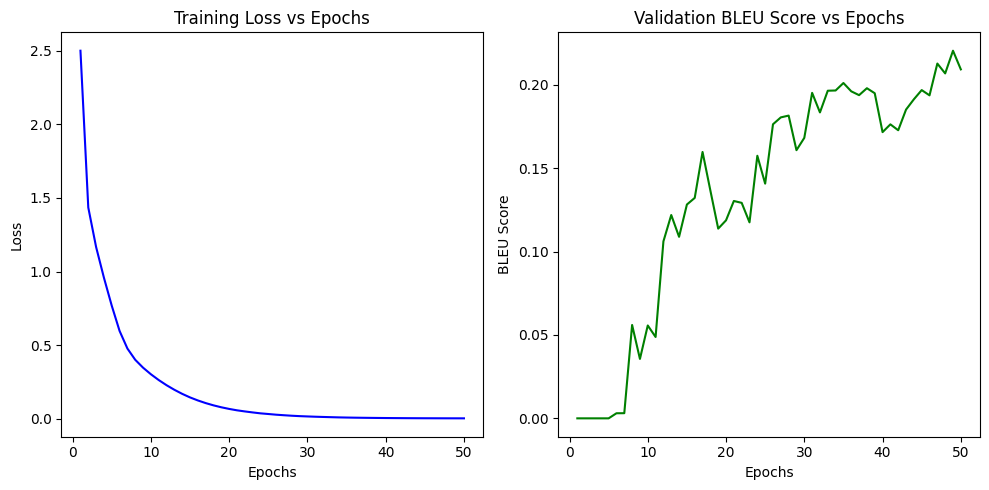

Evaluating model...
Average BLEU Score: 0.3233


In [341]:
fine_tuned_model = fine_tune_t5_model(train_df, val_df, model, tokenizer, epochs=50)

The **BLEU score** ranges from 0 to 1:<br>
1. A BLEU score of 1 means a perfect match between the generated output and reference texts.<br>
2. A BLEU score of 0 means no overlap between the generated output and reference texts.<br>

In practice, BLEU scores typically range between 0 and 1, where scores above 0.7 are generally considered good, but this can vary depending on the task and dataset.


In [342]:
# Test Prediction
new_cve_description = "A vulnerability was found in Netis Netcore Router up to 2.2.6. It has been declared as problematic. Affected by this vulnerability is an unknown functionality of the file param.file.tgz of the component Backup Handler. The manipulation leads to information disclosure. The attack can be launched remotely. The associated identifier of this vulnerability is VDB-217591."
execution_flow = generate_execution_flow(fine_tuned_model, tokenizer, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)


Generated Execution Flow:
::STEP:1:PHASE:Explore:DESCRIPTION:Understand the Rechteinhaber bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei


In [343]:
# Assuming you have a fine-tuned model and tokenizer
fine_tuned_model = fine_tuned_model  # Replace with your fine-tuned model variable
fine_tuned_tokenizer = tokenizer  # Replace with your fine-tuned tokenizer variable

# Specify the directory to save the fine-tuned model and tokenizer
output_dir = "./T5model_with_bleu_score"

# Save the model and tokenizer
fine_tuned_model.save_pretrained(output_dir)
fine_tuned_tokenizer.save_pretrained(output_dir)

print(f"Fine-tuned model and tokenizer saved to {output_dir}")

Fine-tuned model and tokenizer saved to ./T5model_with_bleu_score


In [344]:
# Load the fine-tuned model and tokenizer
saved_model_dir = "./T5model_with_bleu_score"

# Reload the fine-tuned model and tokenizer
mo = T5ForConditionalGeneration.from_pretrained(saved_model_dir).to("cuda" if torch.cuda.is_available() else "cpu")
to = T5Tokenizer.from_pretrained(saved_model_dir)

print(f"Fine-tuned model and tokenizer loaded from {saved_model_dir}")

Fine-tuned model and tokenizer loaded from ./T5model_with_bleu_score


In [348]:
# Test Prediction
new_cve_description = "A vulnerability was found in Netis Netcore Router up to 2.2.6. It has been declared as problematic. Affected by this vulnerability is an unknown functionality of the file param.file.tgz of the component Backup Handler. The manipulation leads to information disclosure. The attack can be launched remotely. The associated identifier of this vulnerability is VDB-217591."
execution_flow = generate_execution_flow(mo, to, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)


Generated Execution Flow:
::STEP:1:PHASE:Explore:DESCRIPTION:Understand the Rechteinhaber bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei der Nutzung von Datenträgern bei


In [1]:
# Test Prediction
new_cve_description = "A vulnerability classified as problematic was found in Supcon InPlant SCADA up to 20230901. Affected by this vulnerability is an unknown functionality of the file Project.xml. The manipulation leads to password hash with insufficient computational effort. Local access is required to approach this attack. The complexity of an attack is rather high. The exploitation appears to be difficult. The exploit has been disclosed to the public and may be used. The identifier VDB-239797 was assigned to this vulnerability. NOTE: The vendor was contacted early about this disclosure but did not respond in any way."
execution_flow = generate_execution_flow(mo, to, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)

NameError: name 'generate_execution_flow' is not defined

In [346]:
!nvidia-smi

Thu Jan  2 10:49:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:07:00.0 Off |                    0 |
| N/A   43C    P0            198W /  400W |   39970MiB /  40960MiB |    100%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----